# Dual PM Task
- get training to work on two trial case
- first evidence for shift between trials

In [2]:
from glob import glob as glob
import itertools

import torch as tr
import numpy as np

from PM_models import *
from PM_tasks import *
from helperfuns_dualPM import *

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


# analysis of saved data

In [2]:
fdir = 'model_data/DualPM_sweep-2trials/'

### train acc

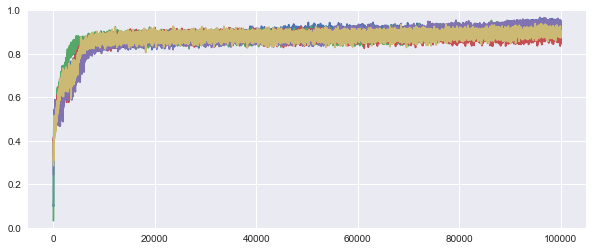

In [4]:
plt.figure(figsize=(10,4))
plt.ylim(0,1)
for seed in range(5):
  fpath = fdir+"LSTM25-EM1-nback_2-pm_maps_3-seed_%i-tracc.npy"%(seed)
  try:
    tracc = np.load(fpath)
  except:
    pass
  plt.plot(mov_avg(tracc,20))

### eval acc

In [67]:
dataL = []
N = 10
for seed in range(N):
  fpath = fdir+"LSTM25-EM1-nback_2-pm_maps_3-seed_%i-evacc.npy"%(seed)
  try:
    evacc = np.load(fpath)
    dataL.append(evacc)
  except:
    pass
  
evacc = np.array(dataL)
evacc.shape

(10, 130)

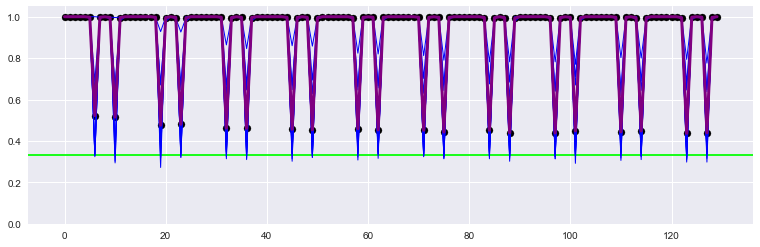

In [80]:
plt.figure(figsize=(13,4))
plt.axhline(0.33,c='lime')
plt.ylim(0,1.05)


M = evacc.mean(0)
S = evacc.std(0)/np.sqrt(len(evacc))

plt.plot(M,c='purple',lw=3,zorder=20)
plt.scatter(range(len(M)),M,c='k')
for subacc in evacc:
  plt.plot(subacc,lw=1,c='b')


### evacc pmprobes over trials

Text(0.5,1,'pm accuracy over trials, N=10')

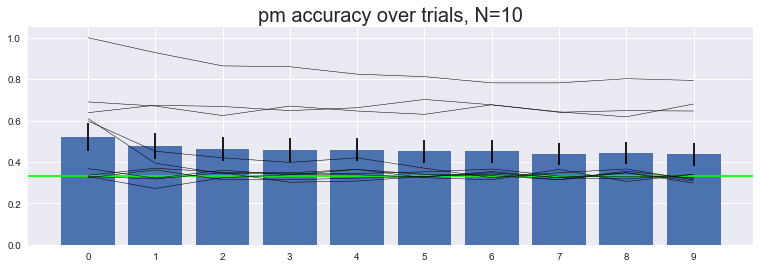

In [89]:
plt.figure(figsize=(13,4))
plt.axhline(0.33,c='lime')
plt.ylim(0,1.05)

pm_acc = []
pm_probe_idx = np.arange(6,130,13)
plt.bar(range(10),M[pm_probe_idx],yerr=S[pm_probe_idx])
for idx,subacc in enumerate(evacc):
  plt.plot(range(10),subacc[pm_probe_idx],c='k',lw=.5)
  pm_acc.append(subacc[pm_probe_idx].mean().round(2))
#   print(idx,subacc[pm_probe_idx].mean().round(2))
  
plt.xticks(range(10))
plt.title("pm accuracy over trials, N=%i"%len(evacc),fontsize=20)
# plt.savefig('figures/DualPM_sweep-2trials/pmacc_by_trial')

In [93]:
print('mean PM accuracy for each subjects:')
print(pm_acc)

mean PM accuracy for each subjects:
[0.65, 0.4, 0.32, 0.66, 0.37, 0.33, 0.84, 0.34, 0.34, 0.33]


### evacc by probe

In [8]:
dataL = []
for seed in range(5):
  fpath = fdir+"LSTM25-EM1-nback_2-pm_maps_3-seed_%i-evacc_byprobe.npy"%(seed)
  try:
    evacc = np.load(fpath)
    dataL.append(evacc)
  except:
    pass
  
evacc2 = np.array(dataL)
evacc2.shape

(5, 3)

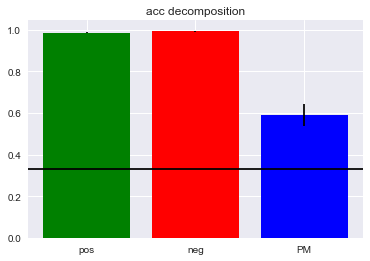

In [9]:
M = evacc2.mean(0)
S = evacc2.std(0)/np.sqrt(len(evacc2))
plt.bar(['pos','neg','PM'],M,yerr=S,color=['g','r','b'])
plt.title('acc decomposition')
plt.axhline(.33,c='k')
# plt.savefig('figures/DualPM_sweep-2trials/acc_by_probe')

# lstm states

### eval and save

In [47]:
neps=500
num_trials=5
testphase_len = 15
instphase_len = 3
trial_len = testphase_len+instphase_len
exp_len = num_trials*trial_len
num_subs = 10

task = TaskDualPM(num_back=2,pm_maps=3,seed=0)

In [4]:
fdir = 'model_data/DualPM_sweep-2trials/'
for seed in range(num_subs):
  # load net
  fpath = fdir+"LSTM25-EM1-nback_2-pm_maps_3-seed_%i-model.pt"%(seed)
  net = NetDualPM(emsetting=1,seed=seed)
  try:
    net.load_state_dict(tr.load(fpath))
  except:
    continue  
  # eval
  acc,states = eval_net(net,task,neps,num_trials,testphase_len,return_states=True)
  # save states
  fpath = fdir+"states/LSTM25-EM1-nback_2-pm_maps_3-seed_%i-states"%(seed)
  np.save(fpath,states)

KeyboardInterrupt: 

### load lstm states

In [6]:
states = -np.ones([num_subs,neps,2,exp_len,25])
for seed in range(num_subs):
  fpath = fdir+"states/LSTM25-EM1-nback_2-pm_maps_3-seed_%i-states.npy"%(seed)
  states[seed] = np.load(fpath)

In [7]:
states.shape

(10, 500, 2, 90, 25)

## state-to-state distances

In [8]:
from scipy.spatial import distance
comp_rdm = lambda M: distance.cdist(M,M,metric='euclidean')

### compute cstate rdms

In [9]:
# mean cstate rdm
state_rdms = -np.ones([num_subs,exp_len,exp_len])
for s in range(num_subs):
  sub_rdms = -np.ones([neps,exp_len,exp_len])
  for e in range(neps):
    sub_rdms[e] = comp_rdm(states[s,e,0,:,:])
  state_rdms[s] = sub_rdms.mean(0)

### plot full rdms

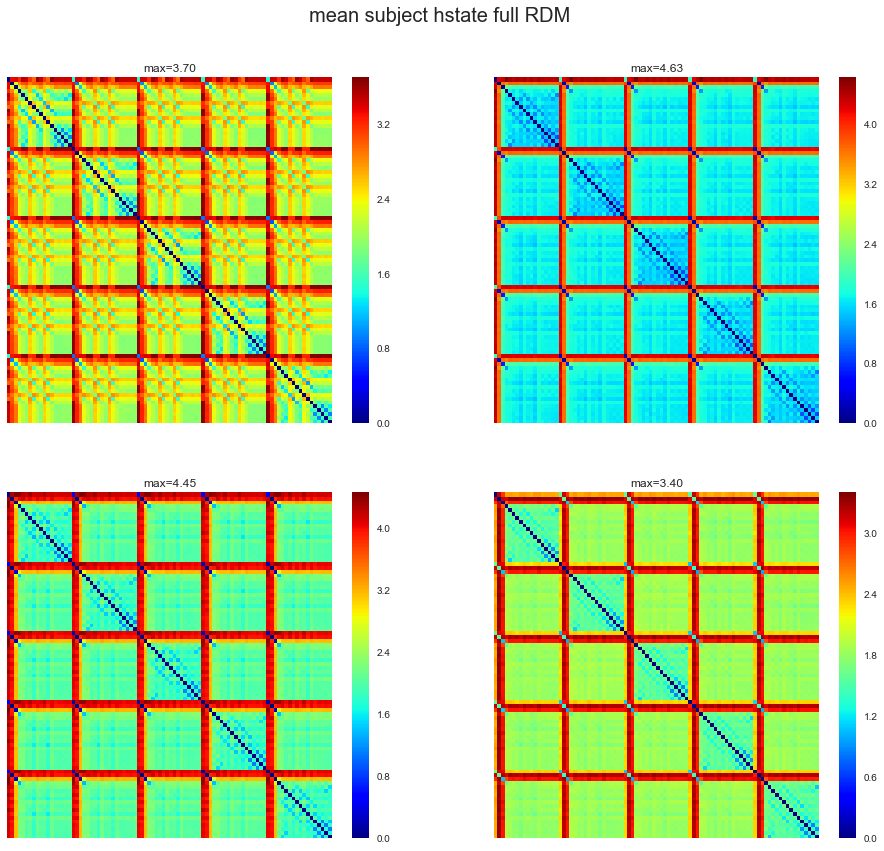

In [43]:
fig,axarr = plt.subplots(2,2,figsize=(16,14),sharex=True,sharey=True);axarr=axarr.reshape(-1)
title = 'mean subject hstate full RDM'
plt.suptitle(title,y=.95,fontsize=20)
for s in range(4):
  ax = axarr[s]
  rdm = state_rdms[s]
  sns.heatmap(rdm,ax=ax,cbar=True,xticklabels=[],yticklabels=[],cmap='jet')
  t = "max=%.2f"%(rdm.max().round(2))
  ax.set_title(t)
plt.savefig('figures/DualPM_sweep-2trials/%s'%title.replace(' ','_'))

### test phase rdm

In [48]:
instphase_idx = np.concatenate([np.arange(t0,exp_len,trial_len) for t0 in range(instphase_len)])
instphase_idx.sort()
testphase_idx = np.delete(np.arange(exp_len),instphase_idx)

In [50]:
test_rdms = -np.ones([num_subs,len(testphase_idx),len(testphase_idx)])
for s in range(num_subs):
  test_rdms[s] = state_rdms[s][testphase_idx,:][:,testphase_idx]

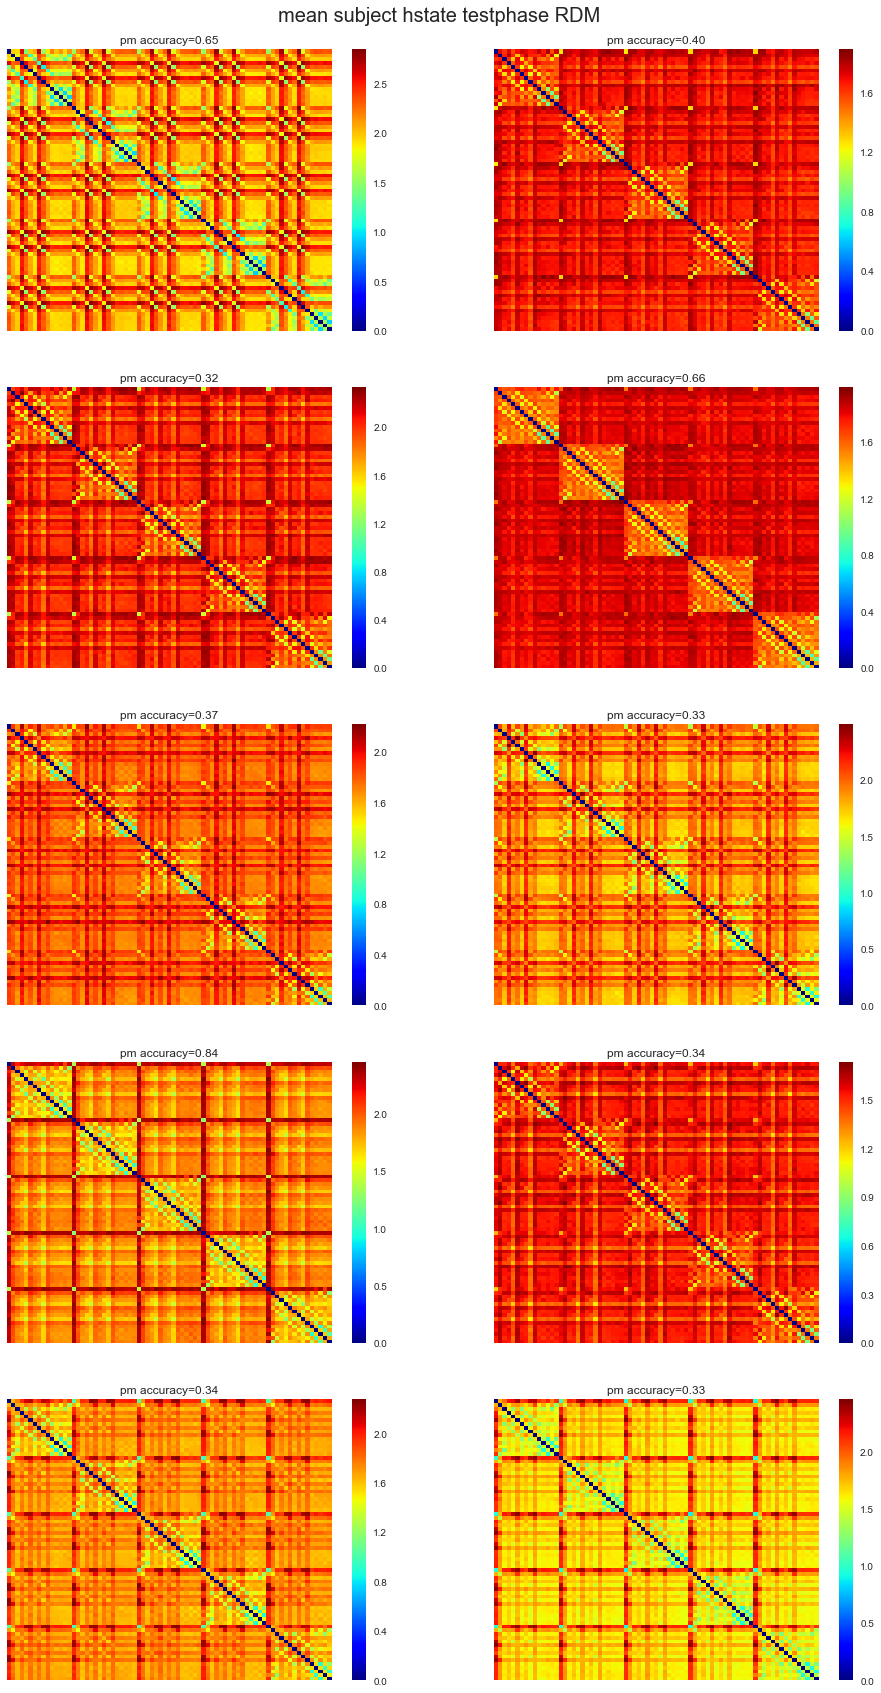

In [100]:
fig,axarr = plt.subplots(5,2,figsize=(16,30),sharex=True,sharey=True);axarr=axarr.reshape(-1)
title = 'mean subject hstate testphase RDM'
plt.suptitle(title,y=.9,fontsize=20)
for s in range(10):
  ax = axarr[s]
  rdm = test_rdms[s]
  sns.heatmap(rdm,ax=ax,cbar=True,xticklabels=[],yticklabels=[],cmap='jet')
  t = "pm accuracy=%.2f"%(pm_acc[s])
  ax.set_title(t)
# plt.savefig('figures/DualPM_sweep-2trials/%s'%title.replace(' ','_'))

### extract trial rdm 

In [57]:
def get_trial_rdm(testphase_rdm,t0,t1,testphase_len=testphase_len):
  """ given the testphase rdm from a given subject
  and two trial numbers, returns the sub-rdm corresponding 
  to the pairwise distances between the states of the two trials
  """
  return testphase_rdm[t0*testphase_len:(t0+1)*testphase_len,
                       t1*testphase_len:(t1+1)*testphase_len]

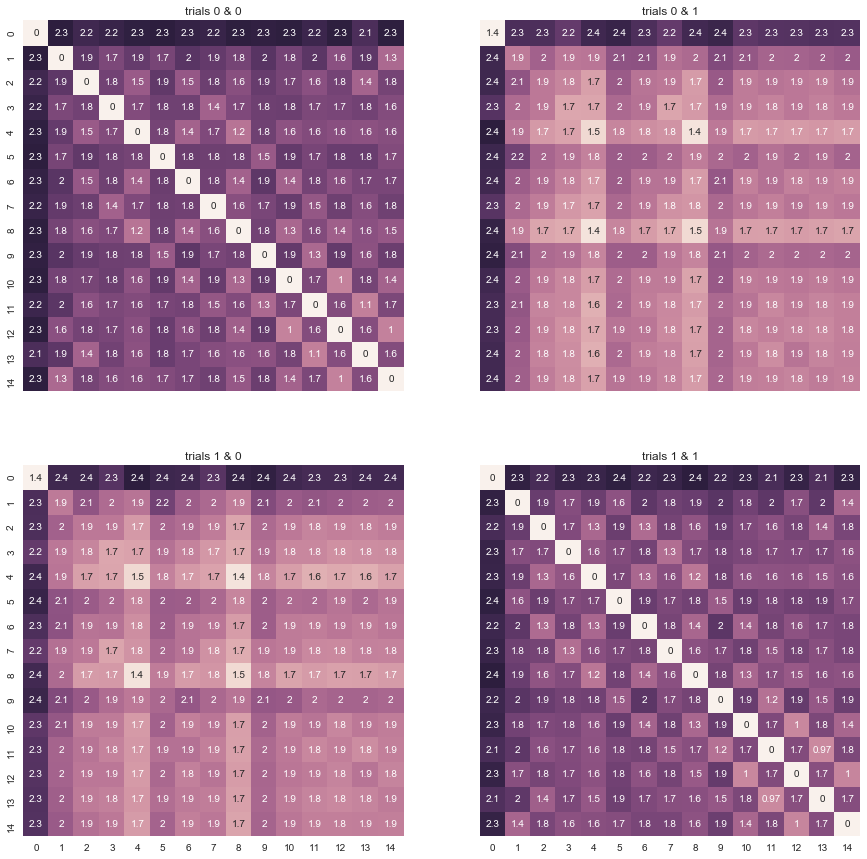

In [101]:
fig,axarr = plt.subplots(2,2,figsize=(15,15),sharex=True,sharey=True); axarr=axarr.reshape(-1)
subj = 6
# subject test rdm  
trials = [0,1]
for idx,(t0,t1) in enumerate(itertools.product(trials,trials)):
  ax = axarr[idx]
  # subject test rdm for trial pair
  trial_rdm = get_trial_rdm(test_rdms[subj],t0,t1,testphase_len=testphase_len)
  sns.heatmap(trial_rdm,annot=True,ax=ax,cbar=False)
  ax.set_title('trials %i & %i'%(t0,t1))


### mean distance between trial pairs

In [59]:
trial_mean_rdm = -np.ones([num_subs,num_trials,num_trials])
for subj in range(5):
  subj_test_rdm = test_rdms[subj]
  for t0,t1 in itertools.product(range(num_trials),range(num_trials)):
    subj_trial_rdm = get_trial_rdm(subj_test_rdm,t0,t1,testphase_len=testphase_len)
    if t0==t1:
      mean_dist = subj_trial_rdm[np.triu_indices(testphase_len,1)].mean()
    else:
      mean_dist = subj_trial_rdm.mean()
    trial_mean_rdm[subj,t0,t1] = mean_dist

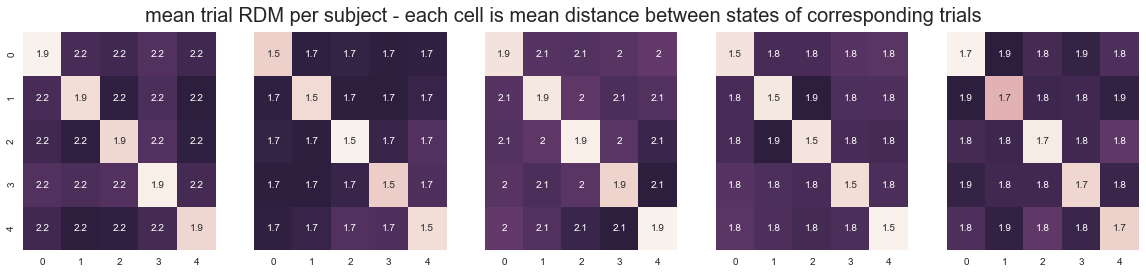

In [60]:
fig,axarr = plt.subplots(1,5,figsize=(20,4),sharex=True,sharey=True)
title = 'mean trial RDM per subject - each cell is mean distance between states of corresponding trials'
plt.suptitle(title,y=.97,fontsize=20)

for s in range(5):
  ax = axarr[s]
  sns.heatmap(trial_mean_rdm[s],ax=ax,annot=True,cbar=False)
  
# plt.savefig('figures/DualPM_sweep-2trials/trial_RDMs')

### wi vs between distance
- controlling for number of interveening timesteps

In [61]:
def get_tstep_matched_idx(nsteps_apart):
  wi_tsteps0 = np.arange(instphase_len,trial_len-nsteps_apart)
  wi_tsteps1 = wi_tsteps0 + nsteps_apart
  bt_tsteps1 = np.arange(trial_len+nsteps_apart-1,trial_len+instphase_len,-1)
  bt_tsteps0 = bt_tsteps1 - nsteps_apart
  return wi_tsteps0,wi_tsteps1,bt_tsteps0,bt_tsteps1


In [62]:
data = -np.ones([num_subs,5])
for nsteps_apart in range(5,10):
  print(nsteps_apart)
  wi_tsteps0,wi_tsteps1,bt_tsteps0,bt_tsteps1=get_tstep_matched_idx(nsteps_apart)
  L = []
  for subj in range(10):
    print(subj)
    rdm = state_rdms[subj]
    wi_dist = rdm[wi_tsteps0,wi_tsteps1].mean()
    bt_dist = rdm[bt_tsteps0,bt_tsteps1].mean()
    data[subj,nsteps_apart-5] = bt_dist-wi_dist
    print(subj,bt_dist-wi_dist)


5
0
0 -0.02339484317302043
1
1 0.10314683366351596
2
2 0.19066706606068928
3
3 0.23259932136115347
4
4 0.01084510614589762
5
5 0.009370841004964658
6
6 0.1678798438854041
7
7 0.09768695966206664
8
8 0.04839725867703937
9
9 0.14275695209396067
6
0
0 -0.0719069244271302
1
1 0.11382920473998515
2
2 0.1682160568354658
3
3 0.29535980135375595
4
4 -0.004972319611632026
5
5 -0.03840036372541222
6
6 0.21442145334691554
7
7 0.09069883934693945
8
8 0.0964942860017679
9
9 0.08934894831506446
7
0
0 0.05753826445385579
1
1 0.05701662333497515
2
2 0.09876684415802695
3
3 0.25838433115538706
4
4 0.01871339649893211
5
5 0.0007926980887187351
6
6 0.0584828032081286
7
7 0.07301020334978836
8
8 0.04921917925159991
9
9 0.07541214052693035
8
0
0 0.4243768281061795
1
1 0.05920253194923797
2
2 0.09515607674871118
3
3 0.2174030484935643
4
4 0.14174248573893866
5
5 0.14445953052252913
6
6 0.011031084929455703
7
7 0.0600957993198612
8
8 0.04863816719195313
9
9 -0.054787353700609165
9
0
0 0.3094247484419055
1
1 

Text(0.5,0,'number of steps apart')

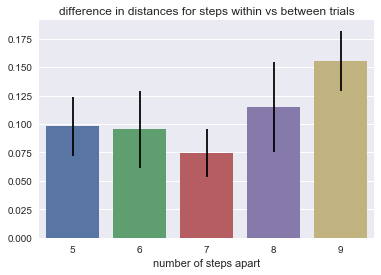

In [63]:
plt.title('difference in distances for steps within vs between trials')
sns.barplot(x=np.arange(5,10),y=data.mean(0),yerr=data.std(0)/np.sqrt(10))
plt.xlabel('number of steps apart')
# plt.savefig('figures/DualPM_sweep-2trials/dist_diff_matched_nsteps')

# train and eval 

### init

In [64]:
# task sweep params
num_back = 2
pm_maps = 3 # number of maps active per trial
seed = 3
EMsetting = 1
## initialize
task = TaskDualPM(num_back=num_back,pm_maps=pm_maps,seed=seed)
net = NetDualPM(emsetting=EMsetting,seed=seed)

### train

In [65]:
gen_data_fn = lambda : task.gen_ep_data(num_trials=2,trial_len=20)
tr_acc = train_net(net,task,neps=100000,gen_data_fn=gen_data_fn,verb=True)

0.0 109.0456
0.2 18.574543


KeyboardInterrupt: 

In [ ]:
plt.plot(mov_avg(tr_acc,10))
plt.ylim(0.9,1)

### eval

In [ ]:
acc = eval_net(net,task)
plt.plot(acc)
plt.ylim(-0.05,1.05)

In [ ]:
acc = eval_byprobe(net,task)
plt.bar(['neg','pos','pm'],np.nan_to_num(acc,0).mean(1),color=['r','g','b'])
plt.ylim(0,1)

# plt.title(title)
# plt.savefig('figures/DualPM_sweep1-fixstimset/'+title)